## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks

SAVE_BEST = [True, False]
FILEPATH = ["./tmp_save_best_true.h5", "./tmp_save_best_false.h5"]
results = {}
#loss_loadback = []
#acc_loadback = []

for i, save_best in enumerate(SAVE_BEST):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    
    model_ckpt = ModelCheckpoint(filepath=FILEPATH[i], 
                                 monitor="val_loss", 
                                 save_best_only=save_best,
                                 save_weights_only=True)

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_tag_name = "Save_best_only - %s" % str(save_best)
    results[exp_tag_name] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

    # Load back
#    model_reload = keras.models.load_model(FILEPATH[i])
#    loss_loadback_v, acc_loadback_v = model_reload.evaluate(x_test, y_test)
#    loss_loadback.append(loss_loadback_v)
#    acc_loadback.append(acc_loadback_v)

W0726 22:06:44.791628 14976 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0726 22:06:44.792602 14976 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0726 22:06:44.803596 14976 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 22:06:44.804574 14976 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 22:06:44.805585 14

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 1s 26us/step - loss: 0.5322 - acc: 0.8451 - val_loss: 1.6395 - val_acc: 0.4929
Epoch 50/50
50000/50000 [==============================] - 1s 26us/step - loss: 0.5172 - acc: 0.8503 - val_loss: 1.6265 - val_acc: 0.4955
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 1s 27us/step - loss: 0.5354 - acc: 0.8470 - val_loss: 1.6488 - val_acc: 0.4906
Epoch 49/50
50000/50000 [==============================] - 1s 26us/step - loss: 0.5202 - acc: 0.8519 - val_loss: 1.6686 - val_acc: 0.4815
Epoch 50/50
50000/50000 [==============================] - 1s 26us/step - loss: 0.5037 - acc: 0.8591 - val_loss: 1.6601 - val_acc: 0.4930


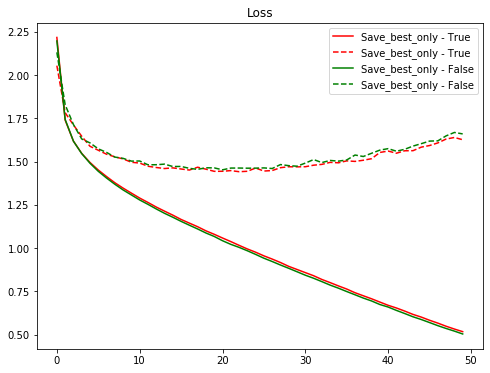

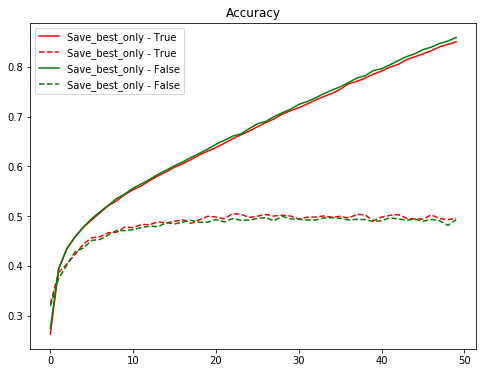

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], "-", label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], "--", label=cond, color=color_bar[i])
#    plt.hlines(y=loss_loadback[i], xmin=0, xmax=len(train_loss), colors=color_bar[i+2], linestyles='--')
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]["train-acc"])), results[cond]["train-acc"], "-", label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]["valid-acc"])), results[cond]["valid-acc"], "--", label=cond, color=color_bar[i])
#    plt.hlines(y=acc_loadback[i], xmin=0, xmax=len(train_loss), colors=color_bar[i+4], linestyles='--')
plt.title("Accuracy")
plt.legend()
plt.show()

In [9]:
model_1 = build_mlp(input_shape=x_train.shape[1:])
model_1.load_weights(FILEPATH[0])
pred_y = model_1.predict(x_test)

In [10]:
pred_y

array([[1.34774195e-02, 1.31748095e-01, 1.88979134e-02, ...,
        1.39332023e-02, 1.16823979e-01, 7.28285452e-03],
       [4.42894362e-02, 1.70863792e-01, 1.14681832e-02, ...,
        3.83793289e-04, 9.50638801e-02, 6.71964049e-01],
       [3.05742949e-01, 2.58296430e-01, 5.35484171e-03, ...,
        6.22952683e-03, 2.03499734e-01, 2.19220027e-01],
       ...,
       [3.45916790e-03, 1.17371406e-03, 2.52477705e-01, ...,
        1.53913361e-03, 2.41572782e-03, 6.74831215e-04],
       [4.14978266e-02, 2.55040765e-01, 1.20215118e-01, ...,
        3.19745764e-02, 4.84488858e-03, 1.73420340e-01],
       [7.40178972e-02, 1.98070370e-02, 3.32399130e-01, ...,
        1.89632878e-01, 4.24957909e-02, 7.23571777e-02]], dtype=float32)

In [11]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [12]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

### 結果討論

save_best_only = True，則val_loss儲存的值為最低loss

save_best_only = False，則val_loss儲存的值為最後一筆